<a href="https://colab.research.google.com/github/josephinebyr/github-slideshow/blob/master/Deep_Learning_Intro_STUDENT_ING2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Satellite Superspectral Images

In this exercise, we will implement two deep learning approaches for classifying images of agricultural parcels from Sentinel2 multispectral images. 
We will implement a **Multi-Layer Perceptron** and a **Convolutional Classifier**.

$\qquad\qquad\qquad\qquad$<img src="https://drive.google.com/uc?id=1sNyYsrExnr6j1YyprhpyllRzgMeepJVU" alt="Drawing"  width="500"/>

The data considered is composed of $10\,000$ agricultural parcels for the training test and $5000$ parcels for the test set. Each parcel is a $10\times32\times32$ image of resolution $32\times 32$ with $10$ spectral bands, captured with the Senintel-2 optical satellite.

The selected parcels follow a nomenclature of $8$ agricultural classes:

> **Class Index** | **Class Name** 
> --- | --- 
> 0  | Meadow
> 1  | Durum Wheat 
> 2  | Spring Cereal
> 3  | Sorgho
> 4  | Leguminous
> 5  | Fodder
> 6  | Ligneous
> 7  | Grapevine


Throughout this exercise, we will implement a full deep learning pipeline from scratch. The structure of the code is already implemented, you will have to complete some of the code denoted by the following flag: ```#TODO```

I have added some assertions in the code `assert` to check your code. only go to the next question if the assert apss succesfuly.

Since this is a notebook, it can be a bit cumbersome to debug. Do not hesitate to create extra cell and visualize the content of the tensors. Alternatively, I encourage you to add `print` to visualize the shape and content of tensors.

## Preliminaries

Select `Runtime→Change runtime type` and select `GPU`.

Let's first start by importing and installing the necessary libraires:

In [1]:
#install on the VM libraries that are not installed by default
!pip install torchnet
!pip install PyDrive
!pip install mock
#general purpose libraires
import math
import numpy as np
from functools import partial
import mock
#format libraries
import h5py
#visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
#machine learning tools
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
#deep learning tools
import torch
import torchnet as tnt
import torch.nn.functional as nnf
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
#collab speific libraries
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

     |████████████████████████████████| 686kB 26.3MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-cp37-none-any.whl size=29743 sha256=e4cb52f5fc6b9715fc43d0562551bb9c55163929425d88b1cf380421e8f414b0
  Stored in directory: /root/.cache/pip/wheels/e1/03/fb/1c212c2f20905cdf97fe39022946cf16b8e66ed754a6663400
  Created wheel for visdom: filename=visdom-0.1.8.9-cp37-none-any.whl size=655251 sha256=33bfedf241e0a236bc1c1c8ed8108fb908ab330c7efd443a600d499ccdb6ee68
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp37-none-any.whl size=5713 sha256=6dba9a45ab8b2664a5a32106596c7ace5e8ed52467e294832c9e427d7fcde21d
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built torchnet visdom torchfile


Let's now download the data. To do this, you must first connect to your Google account to get the authorization to link to my drive. Launch the next cell, click the link, select your account, and click `authorize`. Copy and paste the verification code in the box below.

In [2]:
#Authentification
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':'1owyqy_JKqMF0dhOwroM3J0siZsfRYthk'})
downloaded.GetContentFile('crop_data.h5') 

The dataset is comprised of $10\,000$ patches of $10 \times 32\times 32$ for for training, and $5000$ for testing.
Launch the next cell to read the dataset.

In [10]:
#Data loading
data_file = h5py.File("crop_data.h5",'r')
data_train = data_file['train_data'][:]
labels_train = data_file['train_labels'][:]
data_test = data_file['test_data'][:]
labels_test = data_file['test_labels'][:]

n_train = data_train.shape[0]
n_test = data_test.shape[0]
class_names = ["Meadow", "Durum Wheat", "Spring Cereal", "Sorgho", "Leguminous", "Fodder", "Ligneous", "Grapevine"]

print("%d tiles for training, %d tiles for testing" % (n_train, n_test))
print("Train is of size: %d x %d x %d x %d" % (data_train.shape))

10000 tiles for training, 5000 tiles for testing
Train is of size: 10000 x 10 x 32 x 32


## Data Normalization

Q1) In machine learing in general, and deep learning in particular, it is important for the data to be normalized. Complete the next cell to normalize the train set such that all channels to be of mean $0$ and deviation $1$ over all pixels of all images. Apply the same normalization to the test set, **with the empirical values obtained from the training set.** 

<font color='red'>Why is it important to normalize the test set with the empirical values obtained from the training set and not the test set?</font>

On normalise le train et le test avec les même valeurs pour les raisons suivantes: 
(i) pour que les valeurs soient comparables, ie. une même donnée dans le train et le test soit identique dans les 2 sets 
(ii) utiliser les statistiques du test est de la "triche", ie. de la "test set contamination"



In [11]:
#compute mean and std on all pixels of all patches
#(we keep the original dimension to facilitate broadcasting)
means = np.mean(data_train,axis=(0,2,3), keepdims=True)
stds = np.std(data_train, axis=(0,2,3), keepdims=True)
print("Means = ")
print(means[0,:,0,0])
print("STDs = ")
print(stds[0,:,0,0])

#normalize data to be of mean 0 and std 1
data_train = (data_train - means)/stds
data_test = (data_test - means)/stds
print(data_train[0,:,0,0])
print(data_test[0,:,0,0])

#check that the code is correct
assert(np.all([np.abs(np.mean(data_train[:,i]))<1e-4 for i in range(10)]))
assert(np.all([np.abs(np.std(data_train[:,i])-1)<1e-4 for i in range(10)]))

Means = 
[ 240.50647  369.88947  385.5197   591.1033  1177.0797  1375.755
 1424.6808  1525.0121  1104.5576   648.7599 ]
STDs = 
[ 312.28568  462.83038  521.88306  727.3077  1416.2495  1663.4348
 1721.7817  1831.8516  1350.8748   830.2049 ]
[-0.7701489  -0.7991901  -0.73870903 -0.8127279  -0.83112454 -0.82705677
 -0.8274456  -0.83249766 -0.817661   -0.7814455 ] [-0.7701489  -0.7991901  -0.73870903 -0.8127279  -0.83112454 -0.82705677
 -0.8274456  -0.83249766 -0.817661   -0.7814455 ]



## Data Loader

Any deep learning pipeline rely on a dataloader, which loads a single element (here a patch). Read and understand the function.
Complete the function to compute the patch-wise spatial average if `average=True`.

In [12]:
def patch_loader(patch_index, train=True, average=False):
  """
  load a patch and returns the observation and associated ground truth
  INPUT:
  tile_index = int, index of the tile
  train = bool, train = True if in the train set, False for the test set
  average = if True, compute the spatial average of spectral bands, otherwise returns an image
  OUTPUT
  patch, if average=True [10] float tensor, otherwise [32 x 32 x 10] float tensor 
  label, long int, containing the ground truth class 
  """
  if train:
    patch = data_train[patch_index,:,:,:]
    label = labels_train[patch_index]
  else:
    patch = data_test[patch_index,:,:,:]
    label = labels_test[patch_index]

  if average:#spatial average on all pixels of the parcel:
    patch = patch.mean(axis=(1,2))

  #create torch tensors
  patch = torch.from_numpy(patch.astype('f4')) #use half-float to save space
  label = torch.Tensor([label]).long()  #ground truth must have long int type    
   
  return patch, label

In [15]:
patch, label = patch_loader(500)
print("Patch :", patch[[2,1,0],:,:])
print("The image patch is of shape : %d x %d x %d" % (patch.shape))
print("and its label is %s" % (class_names[label]))
patch, label = patch_loader(200, average=True)
print("The average patch is of shape : %d" % (patch.shape))
print("and its label is %s" % (class_names[label]))

Patch : tensor([[[-0.7387, -0.7387, -0.7387,  ..., -0.7387, -0.7387, -0.7387],
         [-0.7387, -0.7387, -0.7387,  ..., -0.7387, -0.7387, -0.7387],
         [-0.7387, -0.7387, -0.7387,  ..., -0.7387, -0.7387, -0.7387],
         ...,
         [-0.7387, -0.7387, -0.7387,  ..., -0.7387, -0.7387, -0.7387],
         [-0.7387, -0.7387, -0.7387,  ..., -0.7387, -0.7387, -0.7387],
         [-0.7387, -0.7387, -0.7387,  ..., -0.7387, -0.7387, -0.7387]],

        [[-0.7992, -0.7992, -0.7992,  ..., -0.7992, -0.7992, -0.7992],
         [-0.7992, -0.7992, -0.7992,  ..., -0.7992, -0.7992, -0.7992],
         [-0.7992, -0.7992, -0.7992,  ..., -0.7992, -0.7992, -0.7992],
         ...,
         [-0.7992, -0.7992, -0.7992,  ..., -0.7992, -0.7992, -0.7992],
         [-0.7992, -0.7992, -0.7992,  ..., -0.7992, -0.7992, -0.7992],
         [-0.7992, -0.7992, -0.7992,  ..., -0.7992, -0.7992, -0.7992]],

        [[-0.7701, -0.7701, -0.7701,  ..., -0.7701, -0.7701, -0.7701],
         [-0.7701, -0.7701, -0.7701, 

## Data Visualization

Writing some visualization functions to explore the data and the results is very important.
Read and undertsand the definition of `view_patch_RGB` and `show_random_patches`.

In [16]:
#functions used for visualization
def view_patch_RGB(patch, ax):
  """
  INPUT: 
  patch - CxWxH array: the patch to visualize
  ax - subplot axis: in which windows to represent the patch
  """
  patch = np.swapaxes(patch[[2,1,0],:,:],0,-1)
  patch = np.minimum(1,np.maximum(0,(patch+2)/4))
  ax.imshow(patch)
  plt.axis('off')
    
def show_random_patches(num_patches, train=True):
  """ show random patches values
  INPUT: 
  num_patches - int: the number of patches to show
  train - bool: if true loads from the train set, otherwise the test set
  """
  n_row = int(num_patches / 4 + 1) #4 columns
  fig = plt.figure(figsize=(10, n_row * 2.5))
  for i_image in range(num_patches):
    index = np.random.randint(n_train) if train else np.random.randint(n_test)
    patch, label = patch_loader(index, train=train)
    ax = fig.add_subplot(n_row, 4, i_image+1, aspect='equal')
    view_patch_RGB(patch, ax)  
    ax.set_title(class_names[label])

Q2) Use the function `show_random_patches` to represent 16 random tiles of the
**test set**.

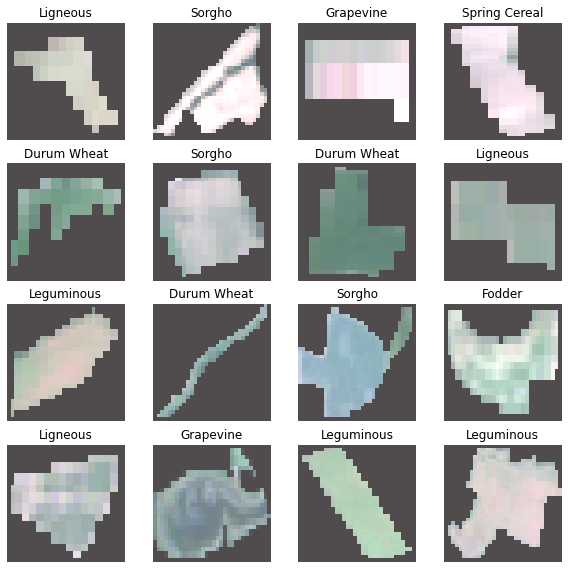

In [17]:
show_random_patches(num_patches=16, train = False)

## Multi-Layer perceptron

We implement a simple MLP operating on the spatial average of each parcel's spectral channels. This networks maps the vector of size $10$ of the spectral average to a vector of $8$ class scores corresponding to the crop classes.


We now define the architecture of our MLP.

The input layer is of size $C$ (the number of bands, here 10) and the last layer is of size $K$ (the number of classes , here $8$). We add $2$ intermediate representations $x_1$ and $x_2$ of size $d_1$ and $d_2$.

Between each representation we add a fully connected layer FC. After each fully connected except the last one, we add a batchnorm and a ReLU activation.
 
The equations describing the function defined by the MLP are as follows:
$$\newcommand{\FC}[2]{\text{FC}_{#1}\left(#2\right)}$$
$$\newcommand{\BN}[1]{\text{BatchNorm}\left(#1\right)}$$
$$\newcommand{\RELU}[1]{\text{ReLU}\left(#1\right)}$$

\begin{align}
x_1  &= \RELU{\BN{\FC{1}{\text{input}}}}\\
x_2  &= \RELU{\BN{\FC{2}{x_1}}}\\
\text{output}  &= \FC{3}{x_2}\\
\end{align}

The size of all tensors is given in the following Table:

> **Tensor**           |    **shape**   |
> -------------------- | -------------------------------------------------|
> input                |  $C$                           |
> $x_1$                |  $d_1$                         | 
> $x_2$                |  $d_2$                         | 
> output               |  K

Q3 Complete the following cell to create the layer and implement the forward function.

In [18]:
class MLP(nn.Module):
  """
  MLP network for semantic segmentation
  """
  
  def __init__(self, n_channels, hidden_width,  n_class, cuda = 1):
    """
    initialization function
    n_channels: int = number of input channel
    hidden_width: int list = width of hidden layers
    n_class : int =  the number of classes
    """
    super(MLP, self).__init__() #necessary for all classes extending the module class

    self.is_cuda = cuda
    
    self.fc1 = nn.Sequential( \
        nn.Linear(in_features=n_channels, out_features=hidden_width[0]), \
        nn.BatchNorm1d(num_features=hidden_width[0]), \
        nn.ReLU(True))
    self.fc2 = nn.Sequential( \
        nn.Linear( in_features=hidden_width[0], out_features=hidden_width[1]), \
        nn.BatchNorm1d(num_features=hidden_width[1]), \
        nn.ReLU(True))
    self.fc3 = nn.Linear(in_features=hidden_width[1], out_features=n_class)
    
    if cuda: #remember wether to use the GPU or not
      self.cuda()
    
  def forward(self,input):
    """
    the foward pass : maps input to output
    """ 
    if self.is_cuda: #input to the GPU at the last second to save some VRAM
      input = input.cuda()

    x1 = self.fc1(input)
    x2 = self.fc2(x1)
    output = self.fc3(x2)
    return output

In [19]:
#==================TEST===============================
#make a batch of 2 patches
patch1, label = patch_loader(0, average=True)
patch2, label = patch_loader(1, average=True)
patches = torch.cat((patch1[None,:],patch2[None,:]),0)
#create classifier
mlp = MLP(10,[128,128],8)
#print layers + number of parameters
print(mlp)
print('Total number of parameters: {}'.format(sum([p.numel() for p in mlp.parameters()])))
#classify batch
pred = mlp(patches)
#check the shape of the outcome
assert(pred.shape == torch.Size([2,8]))

MLP(
  (fc1): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc3): Linear(in_features=128, out_features=8, bias=True)
)
Total number of parameters: 19464



## Evaluation Metrics

Q4 Complete the metric functions belows, defined with respect to the confusion matrix $M$ of size $K \times K$:

* *Overall Accuracy*: a global metric defined as the ratio of correct prediction divided by the number of (annotated) points
    $$
    OA = \frac{\sum_{i}M_{i,i}}
    {\sum_{i,j}M_{i,j}}~.
    $$
* *Class IoU*: this per-class metric is defined as the ratio between true positives divided by the sum of false positives, false negatives and true positives.
    $$
    IoU_i = \frac{M_{i,i}}
    {M_{i,i} + \sum_{j \neq i}\left(M_{i,j} + M_{j,i} \right)}
    ~.
    $$


Make sure you obtain the following:
```
OA = 76,00%
Meadow        : 71.43%
Durum Wheat   : 57.14%
Spring Cereal : 100.00%
Sorgho        : 100.00%
Leguminous    : 100.00%
Fodder        : 66.67%
Ligneous      : 25.00%
Grapevine     : 25.00%
```

In [40]:
class ConfusionMatrix:
  def __init__(self, n_class, class_names):
    self.CM = np.zeros((n_class, n_class)) #the matrix itself
    self.n_class = n_class
    self.class_names = class_names
    
  def add_batch(self, gt, pred):
    #add in the CM a batch of prediction and associated ground truth
    self.CM +=  confusion_matrix(gt, pred, labels = list(range(self.n_class)))

  def overall_accuracy(self):#percentage of correct classification
    return 100 * np.trace(self.CM) / self.CM.sum()

  def class_IoU(self, show = 0):#IoU for each class
    ious = np.diag(self.CM) / (self.CM.sum(0) + self.CM.sum(1) - np.diag(self.CM) )

    if show: #print detailed values
      print('\n'.join('{:13s} : {:3.2f}%'.format(name, 100*iou) for name, iou in zip(self.class_names,ious)))
    #do not count classes that are not present in the dataset in the mean IoU
    return 100*np.nansum(ious) / (np.logical_not(np.isnan(ious))).sum()

In [41]:
m = ConfusionMatrix(8, class_names)
m.add_batch(np.array([0,1,1,5,2,0,0,4,0,5,3,7,8,6,7]), np.array([0,1,0,5,2,0,1,4,0,5,3,6,7,6,7]))
m.add_batch(np.array([0,1,5,1,2,1,0,2,3,6,7]), np.array([0,1,1,1,2,1,0,2,3,7,6]))
print(m.CM)
print("OA :", np.trace(m.CM) / m.CM.sum())
print("OA = %3.2f%%" % (m.overall_accuracy()))
print("mIoU = %3.2f%%" % (m.class_IoU(show=1)))

[[5. 1. 0. 0. 0. 0. 0. 0.]
 [1. 4. 0. 0. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 2. 1.]]
OA : 0.76
OA = 7600.00%
Meadow        : 71.43%
Durum Wheat   : 57.14%
Spring Cereal : 100.00%
Sorgho        : 100.00%
Leguminous    : 100.00%
Fodder        : 66.67%
Ligneous      : 25.00%
Grapevine     : 25.00%
mIoU = 68.15%


Q5) Read in the `train` function following cell. Complete the function `eval`  which performs inference with the trained model. This function computes a prediction and the loss but does not compute gradients nor make an optimizer step.

In [36]:
def train(model, optimizer, loader, args):
  """train for one epoch
  INPUT:
  model = current model
  optimizer = current optimizer
  loader = dataset constituting the epoch
  OUTPUT:
  cm = the confusion matrix over the entire epoch
  lm = the average loss
  """
  model.train() #switch the model in training mode
  
  #tqdm will provide some nice progress bars
  loader = tqdm(loader, ncols=1000)
  
  #will keep track of the loss
  loss_meter = tnt.meter.AverageValueMeter()
  #keep tracks of prediction errors
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  #goes through the entire dataset
  for index, (tiles, label) in enumerate(loader):

    if model.is_cuda: #put label on GPU
      label = label.cuda()
  
    optimizer.zero_grad() #put gradient to zero
    
    pred = model(tiles) #compute the prediction

    loss = nn.functional.cross_entropy(pred,label.squeeze()) #compute the loss

    loss.backward() #compute gradients
   
    optimizer.step() #one gradient descent step
    
    #add the loss to the meter
    loss_meter.add(loss.item()) 
    #fill the confusion matrix
    cm.add_batch(label.cpu().detach().numpy(), pred.argmax(1).view(-1).cpu().detach().numpy())
    
  return cm, loss_meter.value()[0]

def eval(model, loader, args):
  """
  classify the given dataset. DO NOT track gradients
  INPUT:
  model = model to evaluate
  loader = dataset to classify
  OUTPUT:
  cm = the confusion matrix over the entire dataset
  lm = the average loss
  """
  
  model.eval() #switch in eval mode
  
  loader = tqdm(loader, ncols=1000)
  
  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  with torch.no_grad(): #do not compute gradients (saves memory)
  
    for index, (tiles, label) in enumerate(loader):

      if model.is_cuda: #put label on GPU
        label = label.cuda()
    
        pred = model(tiles) #compute the prediction

        loss = nn.functional.cross_entropy(pred,label.squeeze()) #compute the loss

    
        #add the loss to the meter
        loss_meter.add(loss.item()) 
        #fill the confusion matrix
        cm.add_batch(label.cpu().detach().numpy(), pred.argmax(1).view(-1).cpu().detach().numpy())
      
  return cm, loss_meter.value()[0]

The following cell is the entire training sequence. Read and understand the structure.

In [42]:
def train_full(model, args):
  """The full training loop"""
  
  #create train and test dataset with ListDataset (as list of patch index)
  train_set = tnt.dataset.ListDataset(list(range(n_train)),partial(patch_loader, train=True, average=args.average))
  test_set  = tnt.dataset.ListDataset(list(range(n_test)),partial(patch_loader, train=False, average=args.average))
  
  #the loader function will take care of the batching
  train_loader = torch.utils.data.DataLoader(train_set, \
         batch_size=args.batch_size, shuffle=True, drop_last=True)
  test_loader = torch.utils.data.DataLoader(test_set, \
         batch_size=args.batch_size, shuffle=False, drop_last=False)

  #define the optimizer
  #Adam optimizer is always a good guess for classification tasks
  optimizer = optim.Adam(model.parameters(), lr=args.lr)
  
  #defines some color for test and train texts
  TESTCOLOR = '\033[104m'
  TRAINCOLOR = '\033[100m'
  NORMALCOLOR = '\033[0m'
  
  for i_epoch in range(args.n_epoch):
    #train one epoch
    cm_train, loss_train = train(model, optimizer, train_loader, args)
    print(TRAINCOLOR + 'Epoch %3d -> Train Overall Accuracy: %3.2f%% Train mIoU : %3.2f%% Train Loss: %1.4f' % (i_epoch, cm_train.overall_accuracy(), cm_train.class_IoU(), loss_train) + NORMALCOLOR)

    #periodic testing
    if (i_epoch == args.n_epoch - 1) or (args.n_epoch_test != 0 and i_epoch % args.n_epoch_test == 0 and i_epoch > 0):
      #evalue performance over the test set
      cm_test, loss_test = eval(model, test_loader, args)
      print(TESTCOLOR + 'Test Overall Accuracy: %3.2f%% Test mIoU : %3.2f%%  Test Loss: %1.4f' % (cm_test.overall_accuracy(), cm_test.class_IoU(show=1), loss_test) + NORMALCOLOR)
  return model

Q6) Create and train a model with the follwoing parameter in the following cell. 

In [44]:
args = mock.Mock() #stores the parameters
args.n_epoch = 50 #bumber of epochs
args.n_epoch_test = int(5) #periodicity of evaluation on test set
args.batch_size = 16 #size of batch
args.n_class = 8 #number of classes
args.n_channel = 10 #number of channels
args.cuda = 1 #wether to use the GPU
args.lr = 1e-3 #learning rate
args.hidden_width = [256,256] #size of hidden layers
args.average = True #compute spatial average of each patch

#create the model to train
model = MLP(args.n_channel, args.hidden_width, args.n_class)
print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))

#train the model
trained_model = train_full(model, args)

Total number of parameters: 71688


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Epoch   0 -> Train Overall Accuracy: 58.35% Train mIoU : 34.86% Train Loss: 1.1715



Epoch   1 -> Train Overall Accuracy: 63.70% Train mIoU : 41.05% Train Loss: 1.0208



Epoch   2 -> Train Overall Accuracy: 65.13% Train mIoU : 42.62% Train Loss: 0.9830



Epoch   3 -> Train Overall Accuracy: 65.88% Train mIoU : 43.81% Train Loss: 0.9438



Epoch   4 -> Train Overall Accuracy: 67.22% Train mIoU : 45.45% Train Loss: 0.9306



Epoch   5 -> Train Overall Accuracy: 66.81% Train mIoU : 44.88% Train Loss: 0.9184


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Meadow        : 0.79%
Durum Wheat   : 45.98%
Spring Cereal : 44.92%
Sorgho        : 21.38%
Leguminous    : 66.90%
Fodder        : 46.06%
Ligneous      : 58.69%
Grapevine     : 22.74%
Test Overall Accuracy: 59.38% Test mIoU : 38.43%  Test Loss: 1.0464



Epoch   6 -> Train Overall Accuracy: 67.76% Train mIoU : 46.55% Train Loss: 0.9024



Epoch   7 -> Train Overall Accuracy: 68.32% Train mIoU : 46.48% Train Loss: 0.8895



Epoch   8 -> Train Overall Accuracy: 68.71% Train mIoU : 47.07% Train Loss: 0.8828



Epoch   9 -> Train Overall Accuracy: 68.88% Train mIoU : 47.21% Train Loss: 0.8694



Epoch  10 -> Train Overall Accuracy: 68.91% Train mIoU : 47.48% Train Loss: 0.8643



Meadow        : 63.69%
Durum Wheat   : 47.19%
Spring Cereal : 48.00%
Sorgho        : 28.19%
Leguminous    : 70.90%
Fodder        : 43.67%
Ligneous      : 60.60%
Grapevine     : 14.30%
Test Overall Accuracy: 63.18% Test mIoU : 47.07%  Test Loss: 1.0070



Epoch  11 -> Train Overall Accuracy: 69.31% Train mIoU : 48.12% Train Loss: 0.8608



Epoch  12 -> Train Overall Accuracy: 69.36% Train mIoU : 48.16% Train Loss: 0.8575



Epoch  13 -> Train Overall Accuracy: 69.54% Train mIoU : 48.63% Train Loss: 0.8425



Epoch  14 -> Train Overall Accuracy: 69.72% Train mIoU : 48.60% Train Loss: 0.8501



Epoch  15 -> Train Overall Accuracy: 71.06% Train mIoU : 49.99% Train Loss: 0.8253



Meadow        : 65.71%
Durum Wheat   : 50.38%
Spring Cereal : 51.51%
Sorgho        : 35.77%
Leguminous    : 75.67%
Fodder        : 40.29%
Ligneous      : 61.99%
Grapevine     : 16.75%
Test Overall Accuracy: 65.62% Test mIoU : 49.76%  Test Loss: 0.9554



Epoch  16 -> Train Overall Accuracy: 70.41% Train mIoU : 49.51% Train Loss: 0.8343



Epoch  17 -> Train Overall Accuracy: 70.27% Train mIoU : 49.78% Train Loss: 0.8348



Epoch  18 -> Train Overall Accuracy: 71.23% Train mIoU : 50.75% Train Loss: 0.8146



Epoch  19 -> Train Overall Accuracy: 70.78% Train mIoU : 49.75% Train Loss: 0.8212



Epoch  20 -> Train Overall Accuracy: 69.62% Train mIoU : 48.37% Train Loss: 0.8298



Meadow        : 63.90%
Durum Wheat   : 48.79%
Spring Cereal : 50.28%
Sorgho        : 32.00%
Leguminous    : 77.08%
Fodder        : 47.30%
Ligneous      : 58.69%
Grapevine     : 11.66%
Test Overall Accuracy: 64.86% Test mIoU : 48.71%  Test Loss: 0.9431



Epoch  21 -> Train Overall Accuracy: 70.60% Train mIoU : 49.64% Train Loss: 0.8152



Epoch  22 -> Train Overall Accuracy: 71.10% Train mIoU : 50.60% Train Loss: 0.8119



Epoch  23 -> Train Overall Accuracy: 70.77% Train mIoU : 49.66% Train Loss: 0.8023



Epoch  24 -> Train Overall Accuracy: 71.26% Train mIoU : 50.48% Train Loss: 0.7937



Epoch  25 -> Train Overall Accuracy: 71.31% Train mIoU : 50.77% Train Loss: 0.8073



Meadow        : 0.00%
Durum Wheat   : 48.68%
Spring Cereal : 50.31%
Sorgho        : 31.31%
Leguminous    : 64.95%
Fodder        : 42.02%
Ligneous      : 59.69%
Grapevine     : 22.77%
Test Overall Accuracy: 61.28% Test mIoU : 39.97%  Test Loss: 1.0298



Epoch  26 -> Train Overall Accuracy: 71.65% Train mIoU : 51.19% Train Loss: 0.8079



Epoch  27 -> Train Overall Accuracy: 71.78% Train mIoU : 51.06% Train Loss: 0.7956



Epoch  28 -> Train Overall Accuracy: 71.76% Train mIoU : 51.63% Train Loss: 0.7875



Epoch  29 -> Train Overall Accuracy: 71.64% Train mIoU : 50.77% Train Loss: 0.7900



Epoch  30 -> Train Overall Accuracy: 71.68% Train mIoU : 51.11% Train Loss: 0.7938



Meadow        : 61.36%
Durum Wheat   : 49.62%
Spring Cereal : 49.95%
Sorgho        : 31.73%
Leguminous    : 73.47%
Fodder        : 43.86%
Ligneous      : 58.84%
Grapevine     : 22.38%
Test Overall Accuracy: 64.96% Test mIoU : 48.90%  Test Loss: 0.9487



Epoch  31 -> Train Overall Accuracy: 72.40% Train mIoU : 52.45% Train Loss: 0.7806



Epoch  32 -> Train Overall Accuracy: 71.56% Train mIoU : 50.72% Train Loss: 0.7844



Epoch  33 -> Train Overall Accuracy: 72.09% Train mIoU : 51.74% Train Loss: 0.7762



Epoch  34 -> Train Overall Accuracy: 72.20% Train mIoU : 51.73% Train Loss: 0.7805



Epoch  35 -> Train Overall Accuracy: 72.24% Train mIoU : 52.08% Train Loss: 0.7770



Meadow        : 60.70%
Durum Wheat   : 52.63%
Spring Cereal : 49.62%
Sorgho        : 36.06%
Leguminous    : 72.64%
Fodder        : 41.66%
Ligneous      : 60.27%
Grapevine     : 13.25%
Test Overall Accuracy: 65.10% Test mIoU : 48.35%  Test Loss: 0.9513



Epoch  36 -> Train Overall Accuracy: 72.23% Train mIoU : 52.49% Train Loss: 0.7765



Epoch  37 -> Train Overall Accuracy: 72.65% Train mIoU : 52.67% Train Loss: 0.7648



Epoch  38 -> Train Overall Accuracy: 72.22% Train mIoU : 52.11% Train Loss: 0.7663



Epoch  39 -> Train Overall Accuracy: 72.93% Train mIoU : 52.86% Train Loss: 0.7573



Epoch  40 -> Train Overall Accuracy: 72.56% Train mIoU : 52.52% Train Loss: 0.7580



Meadow        : 0.40%
Durum Wheat   : 48.75%
Spring Cereal : 49.31%
Sorgho        : 34.08%
Leguminous    : 70.37%
Fodder        : 48.98%
Ligneous      : 63.92%
Grapevine     : 25.52%
Test Overall Accuracy: 63.36% Test mIoU : 42.66%  Test Loss: 0.9716



Epoch  41 -> Train Overall Accuracy: 72.35% Train mIoU : 52.20% Train Loss: 0.7674



Epoch  42 -> Train Overall Accuracy: 72.10% Train mIoU : 52.10% Train Loss: 0.7590



Epoch  43 -> Train Overall Accuracy: 72.71% Train mIoU : 52.83% Train Loss: 0.7606



Epoch  44 -> Train Overall Accuracy: 72.92% Train mIoU : 52.66% Train Loss: 0.7579



Epoch  45 -> Train Overall Accuracy: 72.74% Train mIoU : 52.31% Train Loss: 0.7613



Meadow        : 48.80%
Durum Wheat   : 49.24%
Spring Cereal : 51.30%
Sorgho        : 37.01%
Leguminous    : 74.77%
Fodder        : 43.83%
Ligneous      : 61.84%
Grapevine     : 20.02%
Test Overall Accuracy: 64.92% Test mIoU : 48.35%  Test Loss: 0.9792



Epoch  46 -> Train Overall Accuracy: 73.06% Train mIoU : 52.71% Train Loss: 0.7546



Epoch  47 -> Train Overall Accuracy: 72.94% Train mIoU : 53.03% Train Loss: 0.7601



Epoch  48 -> Train Overall Accuracy: 72.29% Train mIoU : 51.94% Train Loss: 0.7623



Epoch  49 -> Train Overall Accuracy: 72.97% Train mIoU : 53.20% Train Loss: 0.7575



Meadow        : 22.81%
Durum Wheat   : 48.21%
Spring Cereal : 50.58%
Sorgho        : 32.01%
Leguminous    : 72.38%
Fodder        : 45.21%
Ligneous      : 58.00%
Grapevine     : 27.73%
Test Overall Accuracy: 63.38% Test mIoU : 44.62%  Test Loss: 0.9711


## Convolutional Classifier

$$\newcommand{\Conv}[2]{\text{Conv}_{#1}\left(#2\right)}$$
$$\newcommand{\FC}[2]{\text{FC}_{#1}\left(#2\right)}$$
$$\newcommand{\BN}[1]{\text{BatchNorm}\left(#1\right)}$$
$$\newcommand{\RELU}[1]{\text{ReLU}\left(#1\right)}$$
$$\newcommand{\MAX}[1]{\text{Maxpool}\left(#1\right)}$$
$$\newcommand{\MEAN}[1]{\text{Mean}\left(#1\right)}$$

We will now define a CNN networ, more appropriate for image classification.

The input is an image of size $C\times W\times H$ with C the number of bands (here 10) and W and H the width and height (here 32). The output is a vector of size $K$ (the number of classes , here $8$).

The CNN is composed of a sequence of convolutions to extract local radiometric features and maxpooling operations to reduce the size of the feature map. Then the learned features are averages spatially and to obtain a vector of aggregated feature. Finally, a fully connected layer maps this vector to the class vector.
 
The equations describing the function defined by the MLP are as follows:


\begin{align}
x_1  &= \RELU{\BN{\Conv{1}{\text{input}}}}\\
x_2  &= \RELU{\BN{\Conv{2}{x_1}}}\\
x_3  &= \MAX{x_2}\\
x_4  &= \RELU{\BN{\Conv{3}{x_3}}}\\
x_5  &= \RELU{\BN{\Conv{4}{x_4}}}\\
x_6  &= \MEAN{x_5}\\
\text{output}  &= \FC{1}{x6}\\
\end{align}

The size of all tensors is given in the following Table:

> **Tensor**           |    **&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Shape of Vectors&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**                          |
> -------------------- | --------------------------------------|      
> input                |  $C\times W \times H$                           |
> $x_1$                |  $d_1\times W \times H$                         | 
> $x_2$                |  $d_2\times W \times H$                         | 
> $x_3$                |  $d_2\times \lceil{{W}/{2}}\rceil \times \lceil{{H}/{2}}\rceil$    | 
> $x_4$                |  $d_3\times \lceil{{W}/{2}}\rceil \times \lceil{{H}/{2}}\rceil$                         | 
> $x_5$                |  $d_4\times \lceil{{W}/{2}}\rceil \times \lceil{{H}/{2}}\rceil$                         | 
> $x_6$                |  $d_4$|
> output               |  $K$


Q8) Complete the following cell to define the convolutional classsifier. Make sure that the assert passes.

In [ ]:
class CNN(nn.Module):
  """
  CNN network for image classification
  """  
  def __init__(self, n_channels, conv_width,  n_class, cuda = 1):
    """
    initialization function
    n_channels, int, number of input channel
    hidden_width, int list, width of hidden convolutional layers (4 values)
    n_class = int,  the number of classes
    """
    super(CNN, self).__init__() #necessary for all classes extending the module class
    self.is_cuda = cuda
    self.class_weight = None
    self.maxpool = nn.MaxPool2d(2,2) #maxpooling layer

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=n_channels, out_channels=conv_width[0] , kernel_size=3, padding=1, padding_mode='reflect'), \
        nn.BatchNorm2d(num_features=conv_width[0]), \
        nn.ReLU(True))
    self.conv2 = nn.Sequential( \
        nn.Conv2d(in_channels=#TODO, out_channels=#TODO, kernel_size=3, padding=1, padding_mode='reflect'), \
        nn.BatchNorm2d(num_features=#TODO), \
        nn.ReLU(True))
    self.conv3 = nn.Sequential( \
        nn.Conv2d(in_channels=#TODO, out_channels=#TODO , kernel_size=3, padding=1, padding_mode='reflect'), \
        nn.BatchNorm2d(num_features=#TODO), \
        nn.ReLU(True))
    self.conv4 = nn.Sequential( \
        nn.Conv2d(in_channels=#TODO, out_channels=#TODO, kernel_size=3, padding=1, padding_mode='reflect'), \
        nn.BatchNorm2d(num_features=#TODO), \
        nn.ReLU(True))

    self.fc = nn.Linear(in_features=#TODO,out_features=#TODO)
    
    if cuda: #put the model on the GPU memory
      self.cuda()
    
  def forward(self,input):
    """
    the foward pass : maps input to output
    """  
    if self.is_cuda:
      input = input.cuda()

    x1 = self.conv1(input)
    x2 = #TODO
    x3 = self.maxpool(x2)
    x4 = #TODO
    x5 = #TODO
    x6 = x5.mean(dim=(2,3))
    output = #TODO
    return output

In [ ]:
#==================TEST===============================
#load a batch of 2 patches
patch1, label = patch_loader(0)
patch2, label = patch_loader(1)
patches = torch.cat((patch1[None,:,:,:],patch2[None,:,:,:]),0)
cnn = CNN(10,[16,32,64,64],8)
print(cnn)
print('Total number of parameters: {}'.format(sum([p.numel() for p in cnn.parameters()])))
pred = cnn(patches)
assert(pred.shape == torch.Size([2,8]))

Q9) Complete the following cell, defining the learning procedure for the CNN.

In [ ]:
args = mock.Mock() #stores the parameters
args.n_epoch = 50
args.n_epoch_test = int(5)
args.batch_size = 16
args.n_class = 8
args.n_channel = 10
args.conv_width = [16,64,64,64]
args.cuda = 1
args.lr = 5e-3
args.average = False

#create the model to train
model = CNN(#TODO
print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))

trained_model_CNN = train_full(#TODO

Q10)  Complete the following function which visualizes the feature maps at each step of the model. Launch this viewer on a fully trained model.


In [ ]:
def view_patch_false_color(feat_map, ax):
  """
  visualize a feature_map in RGB space
  """
  fmap_dim = feat_map.shape[1]
  n_pix = feat_map.shape[2]
  #we use a pca to project the emebddings to a RGB space
  pca = PCA(n_components=3)
  pca.fit(np.eye(fmap_dim))
  #we need to adapt dimension and memory allocation to CPU
  fmap_ = feat_map.cpu().detach().numpy().squeeze()
  fmap_ = fmap_.reshape((fmap_dim, n_pix * n_pix)).transpose(1,0)
  color = pca.transform(fmap_)
  #we normalize for visibility
  color = np.maximum(np.minimum(((color - color.mean(1, keepdims = True) +0.5) / (2 * color.std(1, keepdims = True))), 1), 0)
  color = color.reshape((n_pix, n_pix,3), order= 'F')
  ax.imshow(color)
  plt.axis('off')

def view_embeddings(model, patch_index = None, train = False):
  """
  view the feature maps at all levels for a give model
  """
  if patch_index is None:
    patch_index = np.random.randint(n_train) if train \
    else np.random.randint(n_test)
  patch, label = patch_loader(patch_index)

  if model.is_cuda:
    patch = patch.cuda()

  #forms a batch of size 1  
  input = patch[None,:,:,:]
  with torch.no_grad(): #we do not need  to keep track of gradients here
    x1 = #TODO
    x2 = #TODO
    x3 = #TODO
    x4 = #TODO
    x5 = #TODO
    x6 = #TODO

  fig = plt.figure(figsize=(25, 10)) #adapted dimension
  ax = fig.add_subplot(1, 7, 1, aspect=1)
  
  ax.set(title='Input : %d x %d x %d \n %s' %(input.shape[1],input.shape[2],input.shape[3], class_names[label]))
  view_patch_RGB(patch.cpu(), ax)
  ax = fig.add_subplot(1, 7, 2, aspect=1)
  ax.set(title='x1 : %d x %d x %d' %(x1.shape[1:]))
  view_patch_false_color(x1, ax)
  ax = fig.add_subplot(1, 7, 3, aspect=1)
  ax.set(title='x2 : %d x %d x %d' %(x2.shape[1:]))
  view_patch_false_color(x2, ax)
  ax = fig.add_subplot(1, 7, 4, aspect=1)
  ax.set(title='x3 : %d x %d x %d' %(x3.shape[1:]))
  view_patch_false_color(x3, ax)
  ax = fig.add_subplot(1, 7, 5, aspect=1)
  ax.set(title='x4 : %d x %d x %d' %(x4.shape[1:]))
  view_patch_false_color(x4, ax)
  ax = fig.add_subplot(1, 7, 6, aspect=1)
  ax.set(title='x5 : %d x %d x %d' %(x5.shape[1:]))
  view_patch_false_color(x5, ax)
  ax = fig.add_subplot(1, 7, 7, aspect=1)
  ax.set(title='x6 : %d' %(x6.shape[1:]))
  view_patch_false_color(x6[:, :, None, None], ax)

In [ ]:
for i in range(3):
  view_embeddings(trained_model_CNN)

**Data from**
Garnot, V. S. F., Landrieu, L., Giordano, S., & Chehata, N. Satellite Image Time Series Classification with Pixel-Set Encoders and Temporal Self-Attention. In CVPR 2020.

https://github.com/VSainteuf/pytorch-psetae